## Post-processing
#### Here we fit a multioutput random forest model on the area of each of the segmentation classes to identify those classes which should not have existed in the image.
#### We then display segmentation results on test set along with confusion matrix of the classification results


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torchvision.models as models
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torchvision.models as models

from PIL import Image
import json
import os
import random
from scipy.sparse import csr_matrix
import time
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from segmentation_unet import *
from train import *
from postprocessing_func import *
from image_dataset import *
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from joblib import dump, load

import warnings
warnings.filterwarnings('ignore')

### Get label names

In [2]:
f = open('label_dict.json','r')
new_label = json.load(f)
f.close()
label_name = { i['id']+1:i['name'] for i in new_label}
label_name[0] = 'Background'

In [3]:
batch_size = 1
num_workers = 1
sample_per_class = 400
n_epochs = 8
accumulate_steps = 4

base_dir = os.getcwd()
train_image_dir = os.path.join(base_dir,'data','train')
dev_image_dir = os.path.join(base_dir,'data,'dev')
test_image_dir = os.path.join(base_dir,'data','test')

ds,train_dl = dataloader(train_image_dir,'train.csv',batch_size,sample_per_class = 2000)
dev_ds,dev_dl = dataloader(dev_image_dir,'dev.csv',batch_size)
_,test_dl = dataloader(test_image_dir,'test.csv',batch_size)


train = pd.read_csv(os.path.join(dev_image_dir,'dev.csv'))
op_layers = len(train.ClassId.drop_duplicates())
                             

net = UNet(op_layers)
device = torch.device("cuda")
net.to(device)

checkpoint = torch.load(os.path.join(base_dir,"models",'model_55_7.h5py'))
net.load_state_dict(checkpoint['model_state_dict'],strict=False)

11062


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

<All keys matched successfully>

### Train Random Forest on Dev set with input as area of pixels for each class and output as binary vector based on ground truth (one element for each class)

In [5]:

num_classes = 7
threshold = 0.5

y_op_list = torch.zeros((1,num_classes)).to(device)
y_class_list = torch.zeros((1,num_classes)).to(device)

for x,y in dev_dl:
    x,y = x.to(device),y.to(device)
    _,y_op = net_op(net,x,threshold)
    y_class =  y_one_hot(y,num_classes)
    y_op_list = torch.cat([y_op_list,y_op],dim = 0)
    y_class_list = torch.cat([y_class_list,y_class],dim = 0)

y_class_list = y_class_list[1:,1:].to('cpu').numpy()
y_op_list = y_op_list[1:,1:].to('cpu').numpy()

forest = RandomForestClassifier(random_state=1)
model= MultiOutputClassifier(forest, n_jobs=-1)
model.fit(y_op_list,y_class_list)
dump(model,os.path.join(os.getcwd(),'models','post_unet_model.joblib') )

['post_unet_model_dev.joblib']

### Checking Classification accuracy

In [6]:
y_op_list = torch.zeros((1,num_classes)).to(device)
y_class_list = torch.zeros((1,num_classes)).to(device)

for x,y in test_dl:
    x,y = x.to(device),y.to(device)
    _,y_op = net_op(net,x,threshold)
    y_class =  y_one_hot(y,num_classes)
    y_op_list = torch.cat([y_op_list,y_op],dim = 0)
    y_class_list = torch.cat([y_class_list,y_class],dim = 0)

y_class_list = y_class_list[1:,1:].to('cpu').numpy()
y_op_list = y_op_list[1:,1:].to('cpu').numpy()

y_predict = model.predict(y_op_list)
print("Classification Accuracy  : ",((y_op_list> 0).astype(int) == y_class_list).astype('int').sum(axis = 1).mean())
print("Classification Accuracy with Post Processing : ",(y_predict == y_class_list).astype('int').sum(axis = 1).mean())


Classification Accuracy  :  4.93
Classification Accuracy with Post Processing :  4.9


### Plotting 5 instances of model in action (on test set)

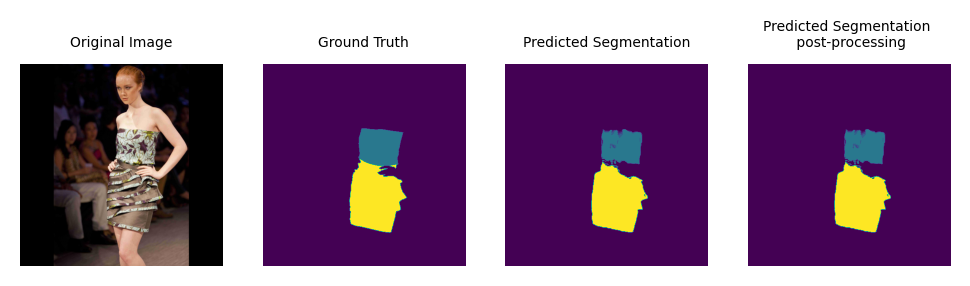

Actual Classes : [0, 2, 5]
Predicted Classes: [0, 2, 5]
Predicted Classes post-processing : [0, 2, 5]


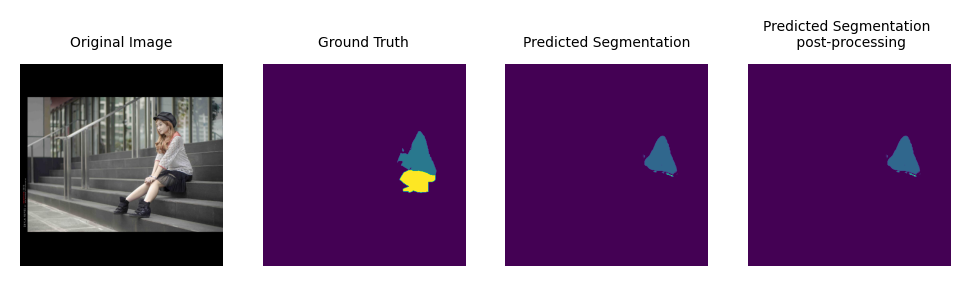

Actual Classes : [0, 2, 5]
Predicted Classes: [0, 2, 6]
Predicted Classes post-processing : [0, 2, 6]


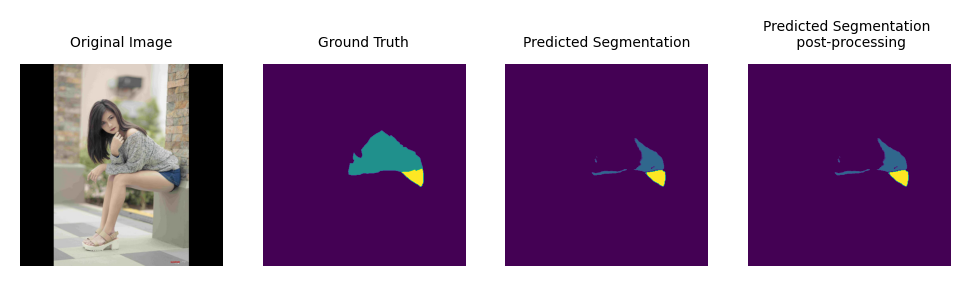

Actual Classes : [0, 3, 6]
Predicted Classes: [0, 2, 6]
Predicted Classes post-processing : [0, 2, 6]


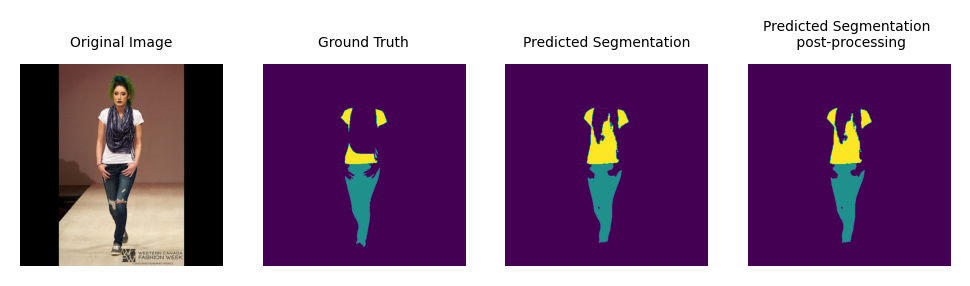

Actual Classes : [0, 1, 2]
Predicted Classes: [0, 1, 2]
Predicted Classes post-processing : [0, 1, 2]


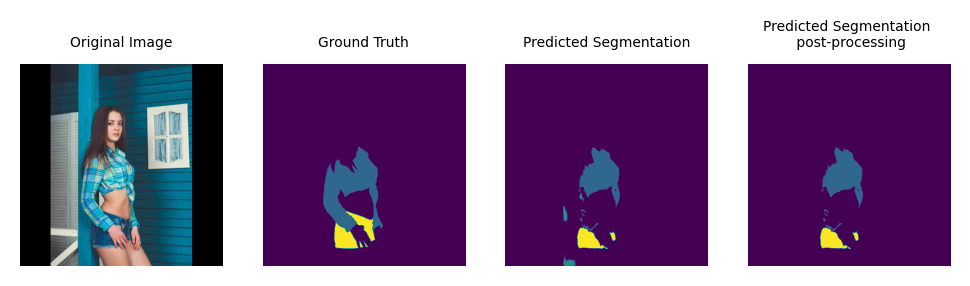

Actual Classes : [0, 2, 6]
Predicted Classes: [0, 2, 3, 6]
Predicted Classes post-processing : [0, 2, 6]


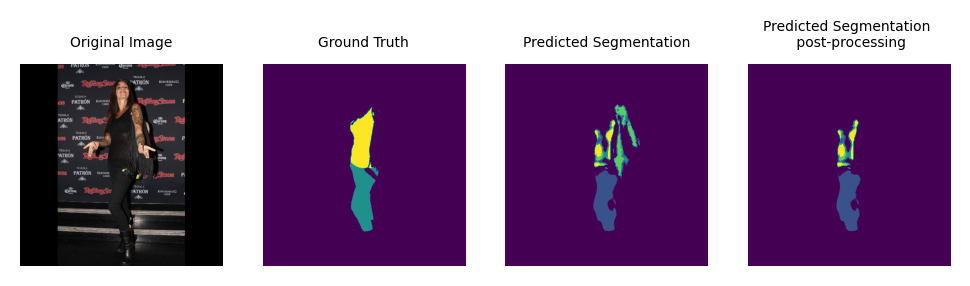

Actual Classes : [0, 1, 2]
Predicted Classes: [0, 1, 2, 3, 4]
Predicted Classes post-processing : [0, 1, 2, 4]


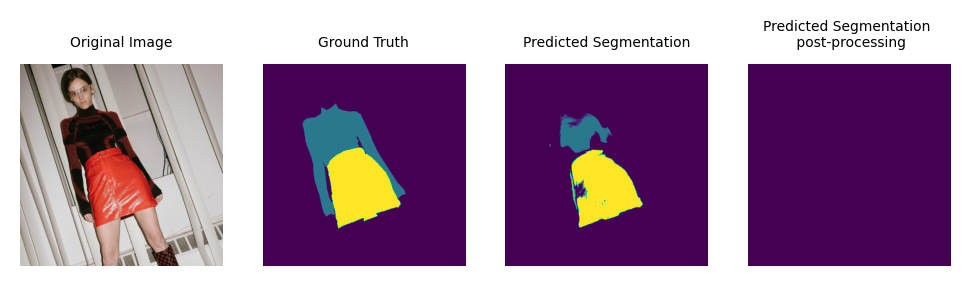

Actual Classes : [0, 2, 5]
Predicted Classes: [0, 2, 3, 4, 5]
Predicted Classes post-processing : [0]


In [7]:

fontsize = 5

params = {'axes.titlesize':fontsize}
pylab.rcParams.update(params)

p_area

threshold = 0.5
i=0

for x,y in test_dl:
    
    plt.figure(dpi = 200)
    
    y_op,y_op_class = net_op(net,x.to(device),threshold)
    y_postop = model.predict(y_op_class[:,1:].to('cpu').numpy())
    y_postop_disp = clean_op(y_postop,y_op)
    
    plt.subplot(1,4,1)
    plt.imshow(x[0,:,:,:].permute([1,2,0]).type(torch.int))
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1,4,2)
    plt.imshow(y[0,:,:])
    plt.title("Ground Truth")
    plt.axis("off")
    
    y_op_disp =  torch.argmax(y_op.to('cpu'),axis = 1)
    plt.subplot(1,4,3)
    plt.imshow(y_op_disp[0,:,:].type(torch.float))
    plt.title("Predicted Segmentation")
    plt.axis("off")
    
    plt.subplot(1,4,4)
    plt.imshow(y_postop_disp[0,:,:].type(torch.float))
    plt.title("Predicted Segmentation \n post-processing")
    plt.axis("off")
    
    plt.show()
    
    print('Actual Classes : ' + str(list(y[0:1,:,:].unique().numpy())))
    print('Predicted Classes: ' + str(list(y_op_disp[0:1,:,:].unique().numpy())))
    print('Predicted Classes post-processing : '+ str(list(y_postop_disp[0:1,:,:].unique().numpy())))
    
    i += 1
    if i==10:
        break



### Generating confusion matrix for model and model + rf configuration

In [8]:
cm_op_row,cm_postop_row,cm_op_col,cm_postop_col = confusion_matrix(net,test_dl,model,device)


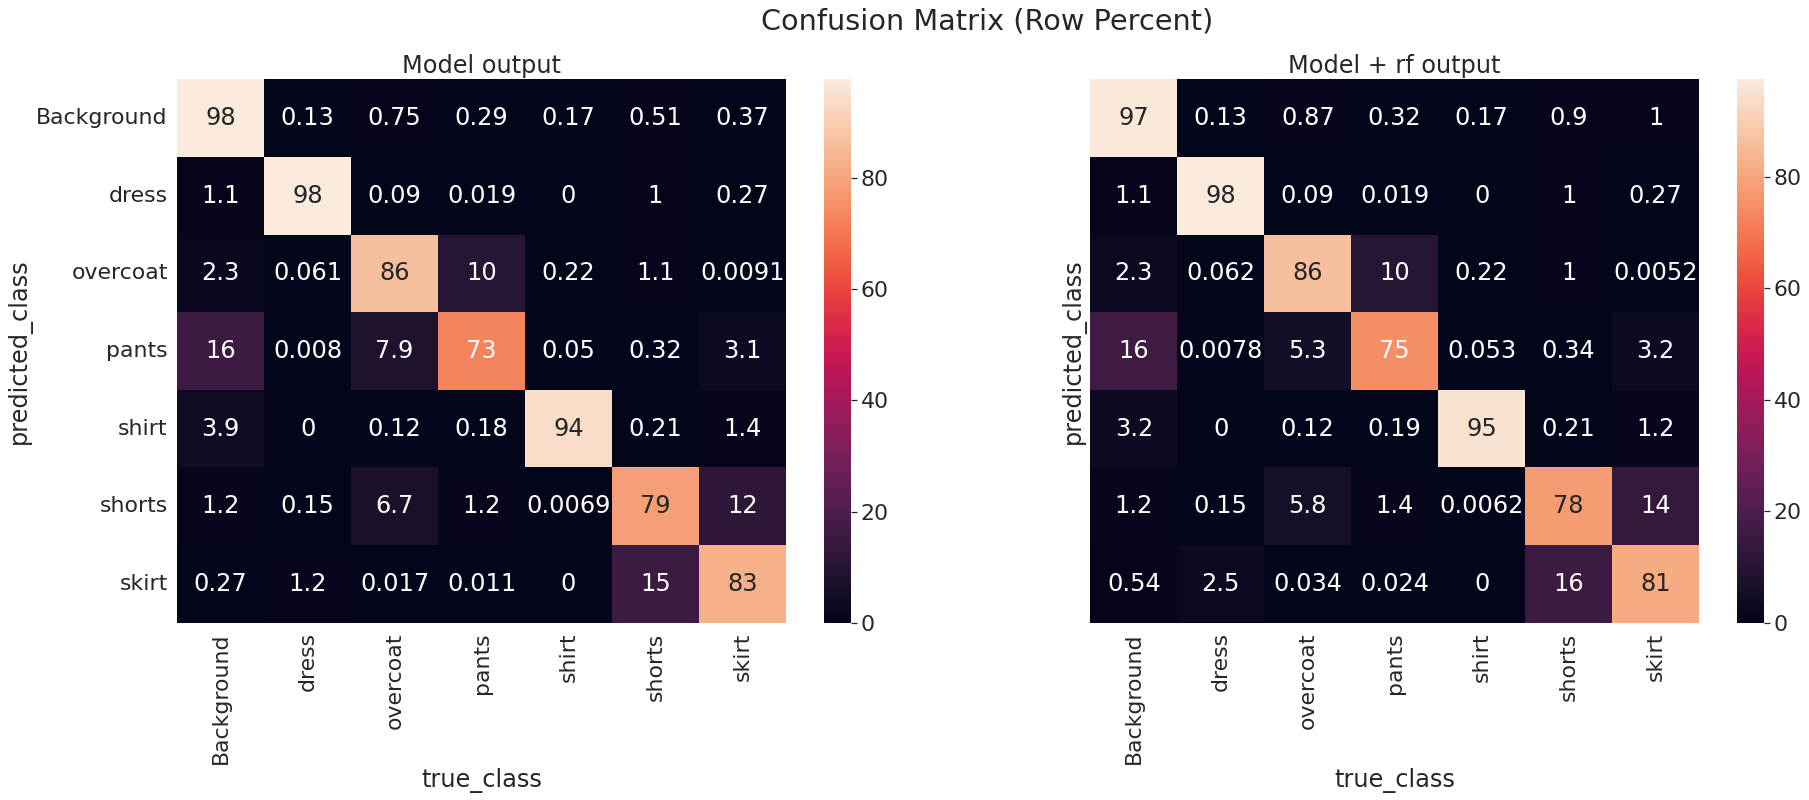

In [9]:
#add labels and heatmap
import seaborn as sns
sns.set(font_scale=2)
fig,ax = plt.subplots(1,2,sharey = True,figsize = (30,10))
fig.suptitle('Confusion Matrix (Row Percent)')
sns.heatmap(cm_op_row, annot=True,ax = ax[0])
ax[0].set_title('Model output')
sns.heatmap(cm_postop_row, annot=True,ax = ax[1])
ax[1].set_title('Model + rf output')
plt.show()

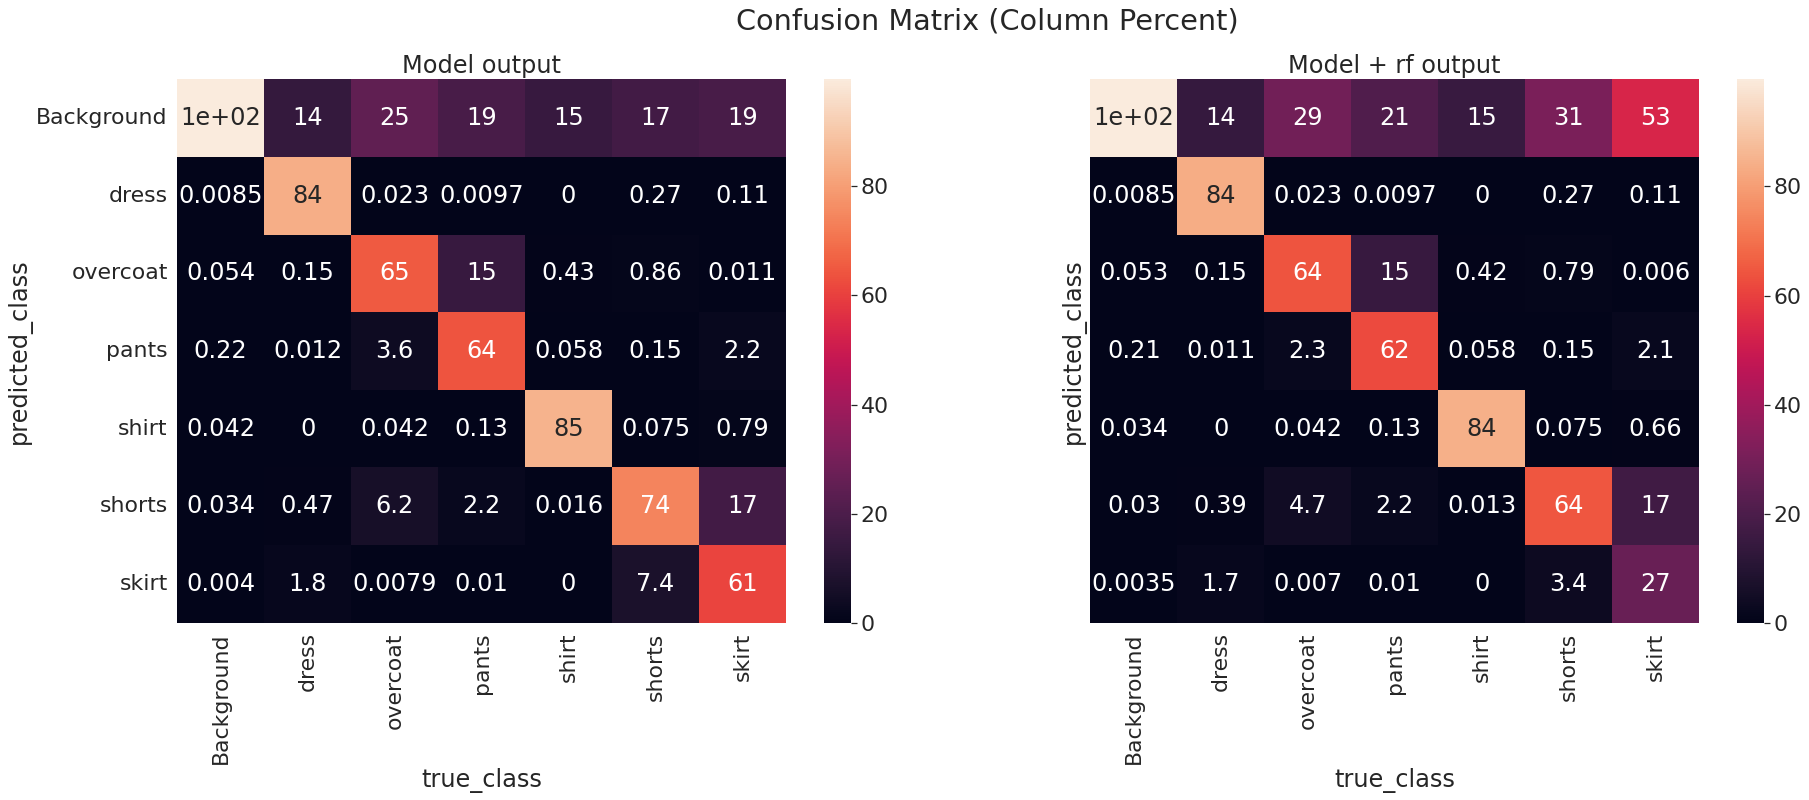

In [10]:

fig,ax = plt.subplots(1,2,sharey = True,figsize = (30,10))
fig.suptitle('Confusion Matrix (Column Percent)')
sns.heatmap(cm_op_col, annot=True,ax = ax[0])
ax[0].set_title('Model output')
sns.heatmap(cm_postop_col, annot=True,ax = ax[1])
ax[1].set_title('Model + rf output')
plt.show()

### Find IOU score:

In [11]:
#iou score:

print('Iou score for model on dev set is : %.3f'%(iou_loss_dl(net,dev_dl,device,7)))
print('Iou score for model on test set is : %.3f'%(iou_loss_dl(net,test_dl,device,7)))

Iou score for model on dev set is : 0.687
Iou score for model on test set is : 0.696


In [12]:
print('Iou score for model + rf on dev set is : %.3f'%(iou_loss_postop_dl(net,dev_dl,device,7)))
print('Iou score for model + rf on test set is : %.3f'%(iou_loss_postop_dl(net,test_dl,device,7)))

Iou score for model + rf on dev set is : 0.844
Iou score for model + rf on test set is : 0.801
